In [1]:
import numpy as np
import torch
import torch.nn as nn
from basic_model import DeepModel_single, gradients
from visual_data import matplotlib_vision

import time
from tqdm import trange
import matplotlib.pyplot as plt

pi = np.pi
nu = 0.01

#### 1d-Burgers方程
求解 $u(x,y)$
$$
    \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - \nu u \frac{\partial^2 u}{\partial^2 x} = 0\\
$$
其解析解为：$ u(t, x) = \frac{2\nu \pi e^{-\pi ^2\nu(t-5)}sin(\pi x)} {2 + e^{-\pi ^2\nu(t-5)}cos(\pi x)}  $

In [2]:
import os
name = 'Burgers-1d-t'
work_path = os.path.join('work', name)
isCreated = os.path.exists(work_path)
if not isCreated:
    os.makedirs(work_path)

class Net(DeepModel_single):
    def __init__(self, planes):
        super(Net, self).__init__(planes, active=nn.Tanh())
        self.nu = 0.01

    def equation(self, inn_var, out_var):
        u = out_var[..., (0,)]
        duda = gradients(out_var, inn_var)
        dudt, dudx = duda[..., (0,)], duda[..., (1,)]
        d2udx2 = gradients(dudx, inn_var)[..., (1,)]
        res = dudt + u * dudx - self.nu / pi * d2udx2
        return res

#### 数据生成

Text(0, 0.5, '$x$')

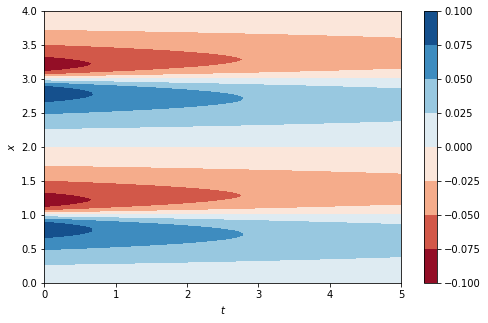

In [3]:
node_t = np.linspace(0, 5, 100, dtype=np.float32)[:, None]
node_x = np.linspace(0, 4, 200, dtype=np.float32)[:, None]

Nt, Nx = node_t.shape[0], node_x.shape[0]
node_t = np.tile(node_t, (1, node_x.shape[0]))  # Nt x Nx
node_x = np.tile(node_x, (1, node_t.shape[0])).T  # Nt x Nx


def get_u(input):
    return (2 * nu * pi * np.exp(-pi ** 2 * nu * (input[..., (0,)] - 5)) * np.sin(pi * input[..., (1,)]))/ \
           (2 + np.exp(-np.pi ** 2 * nu * (input[..., (0,)] - 5)) * np.cos(pi * input[..., (1,)]))

input = np.stack((node_t, node_x), axis=-1)
field = get_u(input) # Nt x Nx

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

nodes_train = torch.tensor(input, dtype=torch.float32).to(device)
field_train = torch.tensor(field, dtype=torch.float32).to(device)

plt.figure(figsize=(8, 5))
plt.contourf(node_t, node_x, field[..., 0], cmap='RdBu')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')

#### 定义训练过程

In [4]:
# 建立网络
Net_model = Net(planes=[2, 50, 50, 50, 1],).to(device)
# 损失函数
L2loss = nn.MSELoss()
# 优化算法
Optimizer = torch.optim.Adam(Net_model.parameters(), lr=0.001, betas=(0.7, 0.9))
# 下降策略
Scheduler = torch.optim.lr_scheduler.MultiStepLR(Optimizer, milestones=[20000, 25000], gamma=0.1)
# 可视化
Visual = matplotlib_vision('/', input_name=('t', 'x'), field_name=('f',))

def train(inn_var, bounds, out_true, model, Loss, optimizer, scheduler, log_loss):

    def closure():

        optimizer.zero_grad()
        out_var = model(inn_var)
        res_i = model.equation(inn_var, out_var)
        ics_loss = Loss(out_var[-1, :], out_true[-1, :])
        bcs_loss_1 = Loss(out_var[:, 0], out_true[:, 0])
        bcs_loss_2 = Loss(out_var[:, -1], out_true[:, -1])
        eqs_loss = Loss(res_i, torch.zeros_like(res_i, dtype=torch.float32))
        bcs_loss = bcs_loss_1 + bcs_loss_2
        loss_batch = bcs_loss + eqs_loss + ics_loss
        loss_batch.backward()

        data_loss = Loss(out_var, out_true)
        log_loss.append([eqs_loss.item(), bcs_loss.item(), ics_loss.item(), data_loss.item()])

        return loss_batch

    optimizer.step(closure)
    scheduler.step()

def inference(inn_var, model):

    out_pred = model(inn_var)
    equation = model.equation(inn_var, out_pred)

    return out_pred, equation

#### 执行训练过程

In [5]:
star_time = time.time()
log_loss = []
pbar = trange(30000)

inn_var = nodes_train
inn_var.requires_grad_(True)

# Training
for iter in pbar:

    learning_rate = Optimizer.state_dict()['param_groups'][0]['lr']
    train(inn_var, [], field_train, Net_model, L2loss, Optimizer, Scheduler, log_loss)

    # if iter > 0 and iter % 200 == 0:
    # print('iter: {:6d}, lr: {:.3e}, eqs_loss: {:.3e}, dat_loss: {:.3e}, bon_loss1: {:.3e}, cost: {:.2f}'.
    #       format(iter, learning_rate, log_loss[-1][0], log_loss[-1][-1], log_loss[-1][1], time.time()-star_time))

    pbar.set_postfix({'lr': learning_rate, 'dat_loss': log_loss[-1][-1], 'cost:':  time.time()-star_time,
                      'eqs_loss': log_loss[-1][0], 'bcs_loss': log_loss[-1][1], 'ics_loss': log_loss[-1][2], })
torch.save({'log_loss': log_loss, 'model': Net_model.state_dict(), }, os.path.join(work_path, 'latest_model.pth'))

100%|██████████| 30000/30000 [05:01<00:00, 99.53it/s, lr=1e-5, dat_loss=0.000197, cost:=301, eqs_loss=3.8e-7, bcs_loss=1.31e-8, ics_loss=2.72e-8]     


#### 训练过程损失可视化

Text(0.5, 1.0, 'training loss')

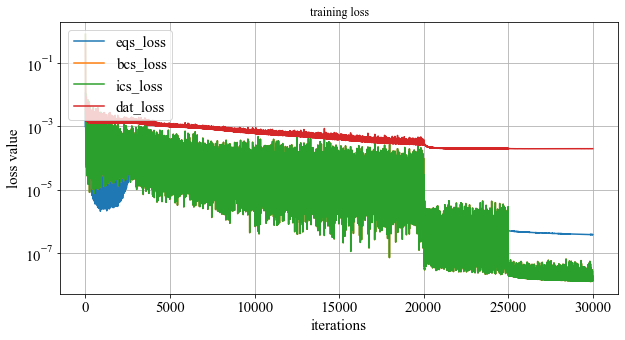

In [6]:
plt.figure(2, figsize=(10, 5))
plt.clf()
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, 0], 'eqs_loss')
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, 1], 'bcs_loss')
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, 1], 'ics_loss')
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, -1], 'dat_loss')
plt.title('training loss')

#### 结果对比

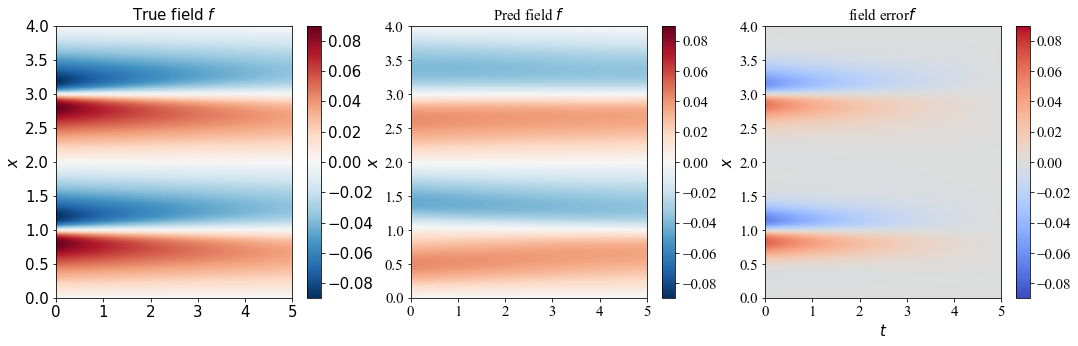

In [7]:
field_pred, equation = inference(inn_var, Net_model)

input_visual = input
field_visual_t = field
field_visual_p = field_pred.detach().cpu().numpy()

fig = plt.figure(figsize=(18, 5))
Visual.plot_fields_ms(field_visual_t, field_visual_p, input_visual)

#### 残差分布及细节对比

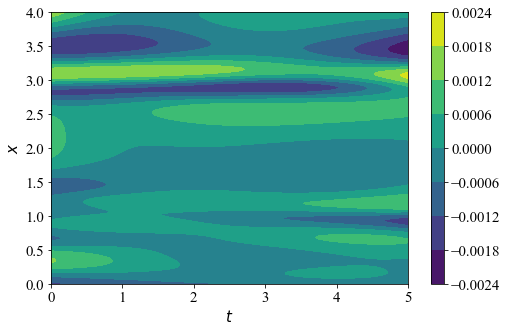

In [8]:
plt.figure(1, figsize=(8, 5))
plt.clf()
plt.contourf(input_visual[..., 0], input_visual[..., 1], equation[..., 0].detach().cpu().numpy())
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.axis()
plt.colorbar()

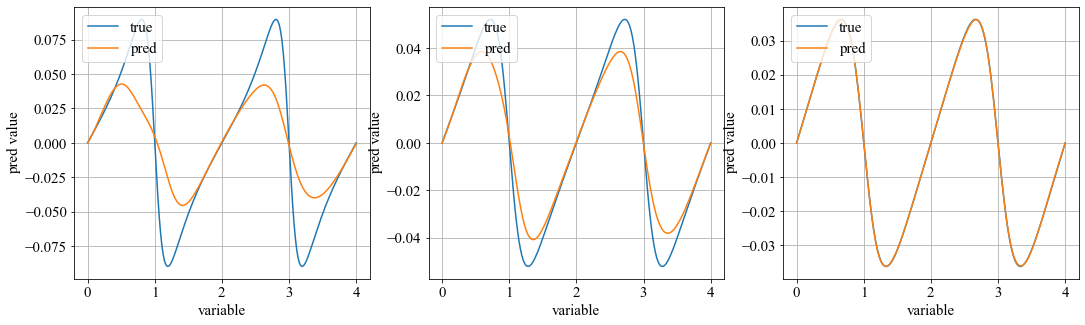

In [9]:
plt.figure(1, figsize=(18, 5))
plt.clf()

plt.subplot(131)
Visual.plot_value(input_visual[0, :, 1], field_visual_t[0, :, 0], 'true')
Visual.plot_value(input_visual[0, :, 1], field_visual_p[0, :, 0], 'pred')
plt.subplot(132)
Visual.plot_value(input_visual[50, :, 1], field_visual_t[50, :, 0], 'true')
Visual.plot_value(input_visual[50, :, 1], field_visual_p[50, :, 0], 'pred')
plt.subplot(133)
Visual.plot_value(input_visual[-1, :, 1], field_visual_t[-1, :, 0], 'true')
Visual.plot_value(input_visual[-1, :, 1], field_visual_p[-1, :, 0], 'pred')